# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**. &rarr;**SORRY, BUT I HAD TO...**

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [ ]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(408., 2.)
        return [new_thrust + random.gauss(0, 0.5) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [ ]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from taskHover import TaskHover

# Set initial simulator conditions. #############################################
# Episode time limit.
runtime = 5.0
# Initial position and rotation.
# Position is 0,0,0 while rotation is randomized by +-0.01 degrees around all axes.
init_pose = np.hstack((np.array([0., 0., 0., 0, 0, 0])))#, (np.random.rand(3)-0.5)*0.02/180*np.pi))
# Initial velocity 0,0,0.
init_velocities = np.array([0., 0., 0.])
# Initial angular velocity 0,0,0.
init_angle_velocities = np.array([0., 0., 0.])
# Output file path.
file_output = 'data.txt'


# Setup the task and agent. #####################################################
task = TaskHover(positionStart=np.array([0,0,10]), positionTarget=np.array([0,0,10]), nActionRepeats=3, runtime=runtime)
agent = Basic_Agent(task)
reward = 0
done = False


# Specify values to be tracked. #################################################
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
results = {x : [] for x in labels}


# Run the simulation and save the results. ######################################
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        # Get rotor speeds from agent.
        rotor_speeds = agent.act()
        # Run the simulator to produce a new state and reward.
        state, reward, done = task.step(rotor_speeds)
        # Save data.
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds) + [reward]
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        # Stop if episode has ended.
        if done:
            break

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import plot
plot.plot(results, fancy=True)

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.


## Prelude I: Pendulum environment
As the DDPG agent is fairly complex and it is suggested in the project instructions I decided to test the DDPG agent on the Pendulum environment first.

I first implemented the agent using the code provided on the Udacity website.

Then I added more features according to ####[Lillicrap (2016)]()####
- Actor and critic networks have two hidden layers with 400 and 300 each
- Actor learning rate: 10e-4, critic learning rate 10e-3
- The critic includes the action inputs at the second layer
- Batch normalization is added to all layers except the output layers
- Random uniform weight and bias initializers with limits [-3e-3, 3e-3] (actor) and [-3e-4, 3e-4] (critic) for the output layers
- L2 weight decay for critic
- Use tanh activation for actions as it has zero mean ([source](https://dl-nd.slack.com/archives/C3QVCQHGW/p1525815705000352))
- Modified the noise code to include a decay over time so there is less and less exploration from episode to episode

The resulting code for learning the pendulum task can be found below.

In [ ]:
# Load environment.
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import gym
import sys
import numpy as np
from matplotlib import pyplot as plt
from agentDDPGKeras import AgentDDPG
#from keras import backend as K
#print("Using Keras backend device {}".format(K.tensorflow_backend._get_available_gpus()[0]))


env = gym.make('Pendulum-v0')
env.reset()
print("Action space: continuous from {} to {}.".format(env.action_space.low[0], env.action_space.high[0]))
print("State space: continuous, {}-dimensional.".format(env.observation_space.shape[0]))

# Hyperparameters.
hp = {}
'''
hp['noiseMu'] = 0.0
hp['noiseTheta'] = 0.15
hp['noiseSigmaStart'] = 0.3
hp['noiseReduction'] = 0.1
hp['noiseDecay'] = 0.01
# Discount factor.
hp['gamma'] = 0.99
# Soft update factor for target params.
hp['tau'] = 0.0003
# Actor network parameters.
hp['actorArch'] = [400,300]
hp['actorAF'] = 'relu'
hp['actorBN'] = True
hp['actorLR'] = 0.001
hp['actorDO'] = False
hp['actorDORate'] = 0.1
# Critic network parameters.
hp['criticArch'] = [[400,300],[300],[]] # states, actions, combined
hp['criticAF'] = 'relu'
hp['criticBN'] = True
hp['criticLR'] = 0.0005
hp['criticDO'] = False
hp['criticDORate'] = 0.1
# Replay buffer.
hp['replaySize'] = 100000
hp['replayBatch'] = 64
hp['nReplayBatches'] = 1
'''
hp['noiseMu'] = 0.0
hp['noiseTheta'] = 0.15
hp['noiseSigmaStart'] = 0.2
hp['noiseReduction'] = 0.1
hp['noiseDecay'] = 0.01
# Discount factor.
hp['gamma'] = 0.99
# Soft update factor for target params.
hp['tau'] = 0.001
# Actor network parameters.
hp['actorArch'] = [400,300]
hp['actorAF'] = 'relu'
hp['actorBN'] = True
hp['actorLR'] = 0.001
hp['actorDO'] = False
hp['actorDORate'] = 0.1
# Critic network parameters.
hp['criticArch'] = [[400,300],[300],[]] # states, actions, combined
hp['criticAF'] = 'relu'
hp['criticBN'] = True
hp['criticLR'] = 0.0001
hp['criticDO'] = False
hp['criticDORate'] = 0.1
# Replay buffer.
hp['replaySize'] = 100000
hp['replayBatch'] = 64
hp['nReplayBatches'] = 1

agent = AgentDDPG(env, hp)
print("Agent created.")


num_episodes = 1000

# Data recording.
rewardSums = []
actions = []
positions = []
velocities = []





print("Starting training.")
for i_episode in range(1, num_episodes+1):
    t = 0
    actionRecord = []
    stateRecord = []
    noiseRecord = []
    
    # Reset the agent.
    # This resets the noise sampler and the environment.
    state = agent.reset_episode()
    
    while True:
        stateRecord.append(state)
        # Render the environment. Disable to speed up.
        #env.render(mode='human')#close=True)
        
        # Choose an action.
        # This lets the actor predict a new action
        # plus adding some noise for exploration.
        action, noise = agent.act(state)
        actionRecord.append(action)
        noiseRecord.append(noise)
        
        # Let the environment react to the chosen action.
        next_state, reward, done, info = env.step(action)        
        
        # Let the agent process the next state and reward.
        # This adds the results to memory and does a learning
        # step if enough memory tuples have been recorded.
        agent.step(action, reward, next_state, done)
        
        # Set new current state.
        state = next_state
                
        
        if done:
            # Decay noise.
            agent.noise.decay()
            
            # Save data.
            rewardSums.append(agent.rewardSum)
            actions.append(actionRecord)
            positions.append(list(np.array(stateRecord)[:,0]))
            velocities.append(list(np.array(stateRecord)[:,1]))
            
            # Display 
            display.clear_output(wait=True)
            print("\rEpisode = {:4d}, reward sum = {:7.3f}, noise_scale = {:7.4f}".format(
                i_episode, agent.rewardSum, agent.noise.sigmaCurrent), end="")  # [debug]
            
            # Display plots.
            fig = plt.figure(figsize=(20,6))
            #ax0 = plt.subplot2grid((3, 9), (0, 0), colspan=3, rowspan=3)
            ax0 = plt.subplot2grid((3, 9), (0, 0), colspan=3, rowspan=3)
            ax1 = plt.subplot2grid((3, 9), (0, 3), colspan=3, rowspan=3, projection='polar')
            ax2 = plt.subplot2grid((3, 9), (0, 6), colspan=3, rowspan=1)
            ax3 = plt.subplot2grid((3, 9), (1, 6), colspan=3, rowspan=1)
            ax4 = plt.subplot2grid((3, 9), (2, 6), colspan=3, rowspan=1)
            
            # Sample the state space to get some action values.
            '''
            n = 20
            positionSample = np.tile(np.linspace(-1.2, 0.6, n), n)
            velocitySample = np.repeat(np.linspace(-0.07, 0.07, n), n)
            actionSample = [agent.actor_target.model.predict(np.array([[p, v]])) for p, v in zip(positionSample, velocitySample)]
            cLevels = [-1.0, 1.0]
            im = ax0.contourf(np.linspace(-1.2, 0.6, n), np.linspace(-0.07, 0.07, n), np.reshape(actionSample, [n,n]), cmap='jet', vmin=-1.0, vmax=1.0)#levels=cLevels)
            fig.colorbar(im, ax=ax0, ticks=cLevels)
            ax0.set_title('Policy')
            '''
            # Plot reward.
            runningAvgLength = 20
            ax0.plot(rewardSums)
            if len(rewardSums) > runningAvgLength:
                rewardSumsAvg = []
                for i in range(runningAvgLength, len(rewardSums)):
                    rewardSumsAvg.append(np.mean(rewardSums[i-runningAvgLength:i]))
                ax0.plot(range(runningAvgLength,len(rewardSums)), rewardSumsAvg)
            ax0.set_title('Reward')
            ax0.set_ylim(-2000, 0)
            
            # Plot angle.
            #ax2.plot([0, num_episodes], [0,0], c='k', linewidth=0.5) # Plot goal position
            #ax2.plot(np.arctan2(-np.array(stateRecord)[:,1],-np.array(stateRecord)[:,0]), label='Angle')
            #ax2.set_title('Angle')
            #ax2.set_ylim(-np.pi-0.2, np.pi+0.2)
            #ax2.set_xticks([])
            ax1.plot(np.arctan2(np.array(stateRecord)[:,1],np.array(stateRecord)[:,0]), np.linspace(0.3, 1, np.array(stateRecord).shape[0]))
            ax1.set_theta_zero_location("N")
            ax1.set_rticks([])
            #ax1.set_ylabel('Time')
            ax1.set_title('Angle over episode')
            
            ax2.plot([0, len(stateRecord)], [0,0], c='k', linewidth=0.5)
            ax2.plot(actionRecord, label='Action + noise')
            ax2.plot([a - n for a, n in zip(actionRecord, noiseRecord)], label='Action')
            ax2.set_ylim(-3, 3)
            ax2.set_title('Action')
            ax2.legend(loc=4)
            ax2.set_xticks([])
            
            ax3.plot([0, len(stateRecord)], [0,0], c='k', linewidth=0.5)
            ax3.plot(np.array(stateRecord)[:,0], label='cos(theta)')
            ax3.plot(np.array(stateRecord)[:,1], label='sin(theta)')
            ax3.legend(loc=4)
            ax3.set_ylim(-1.2, 1.2)
            ax3.set_title('Position over episode')
            ax3.set_xticks([])
            
            ax4.plot([0, len(stateRecord)], [0,0], c='k', linewidth=0.5)
            ax4.plot(np.array(stateRecord)[:,2], label='Angular velocity')
            ax4.set_ylim(-9, 9)
            ax4.set_title('Angular velocity over episode')
            plt.tight_layout()
            plt.show()
            break
        
        t += 1
env.close()
K.clear_session()

In [ ]:
import gc
del agent
K.clear_session()
for i in range(10): gc.collect()

The agent is able to learn but it does not really converge to a stable state and would most of the time also unlearn. It would not learn as good as proposed by [Lillicrap (2016)](https://arxiv.org/pdf/1509.02971.pdf) where it performs as good as a planning algorithm, even with the exact same hyper parameters.

My mentor advised to play around with the hyper-parameters so I did.
I tested the following parameters:
* Noise sigma: 0.3, 0.2, 0.1
* Gamma: 0.99, 0.97, 0.95, 0.90
* With and without Batch Normalization for both, Actor and Critic
* Tau: 0.001, 0.0005, 0.0001
* Actor learn rates 0.01, 0.005, 0.001, 0.0005, 0.0001
* Critic learn rates: 0.01, 0.005, 0.001, 0.0005, 0.0001
* Batch size: 32, 64, 128
* Replay memory size: 10000, 50000, 100000

However, most of the parameters only made it worse or were very hard to interprete. Some of the parameter test runs are shown below.
![Pendulum results](figurePendulum.png "Pendulum parameter tests")



## Prelude II: Pendulum with TFlearn
While searching the internet for ways to improve this I found a TFlearn implementation of DDPG by Patrick Emami [here](https://github.com/pemami4911/deep-rl/tree/master/ddpg) and decided to give it a try.

I took the code and built it into the same structure that was given in the Udacity code to make things easier. All the corresponding files have '*Tflearn*' in their filenames while the others are marked by '*Keras*'.

I then set the hyper-parameters from [Lillicrap (2016)](https://arxiv.org/pdf/1509.02971.pdf), <font color='red'>TODO</font> added L2 weight decay random uniform weight initialization with limits of $[-\frac{1}{\sqrt{f}},  \frac{1}{\sqrt{f}}]$ as described in [Lillicrap (2016)](https://arxiv.org/pdf/1509.02971.pdf)

Episode = 1000, reward sum = -227.236


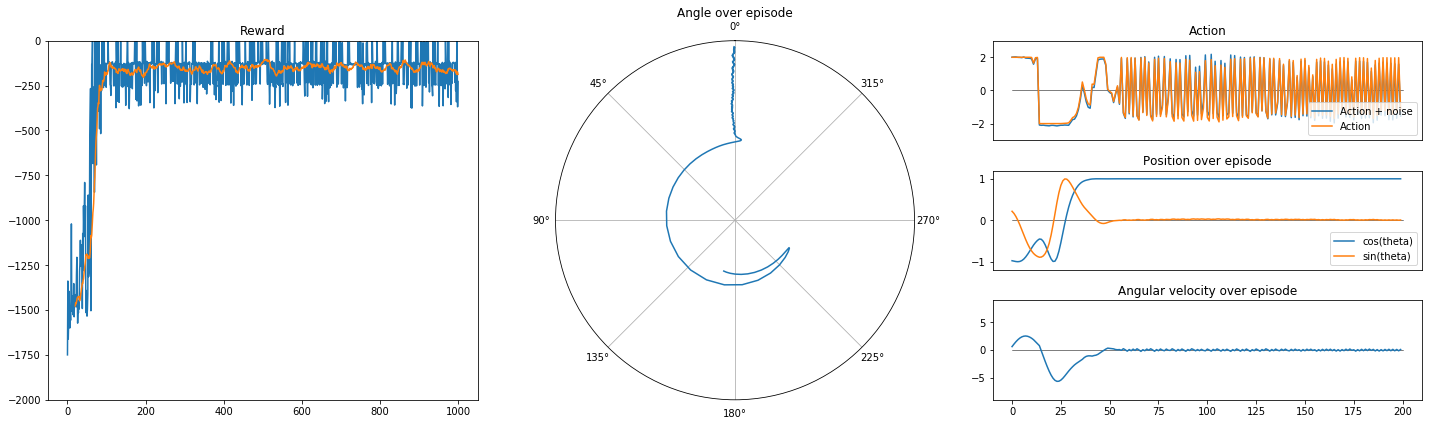

In [14]:
# Load environment.
%load_ext autoreload
%autoreload 2

from IPython import display
import sys
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import tflearn
import gym
from agentDDPGTflearn import AgentDDPG

# Hyperparameters. These are the original values from the DDPG paper.
hp = {}
hp['noiseMu'] = 0.0
hp['noiseTheta'] = 0.15
hp['noiseSigmaStart'] = 0.2
hp['noiseSigmaEnd'] = 0.2
hp['noiseDecay'] = 0.01
# Discount factor.
hp['gamma'] = 0.99
# Soft update factor for target params.
hp['tau'] = 0.001
# Actor network parameters.
hp['actorActivation'] = 'relu'
hp['actorBatchNorm'] = True
hp['actorLearningRate'] = 0.0001
hp['actorDropout'] = False
hp['actorDropoutRate'] = 0.1
# Critic network parameters.
hp['criticActivation'] = 'relu'
hp['criticBatchNorm'] = True
hp['criticLearningRate'] = 0.001
hp['criticDropout'] = False
hp['criticDropoutRate'] = 0.1
# Replay buffer.
hp['bufferSize'] = 1000000
hp['batchSize'] = 64
hp['nReplayBatches'] = 1
# Random seed.
hp['randomSeed'] = 1234
hp['renderGym'] = False


num_episodes = 1000

# Clear tensorflow graph and all variables.
# Otherwise we cannot run this cell multiple times
# without restarting the kernel.
tf.reset_default_graph()

with tf.Session() as sess:

    tf.set_random_seed(int(hp['randomSeed']))

    # Set up environment.
    env = gym.make('Pendulum-v0')
    env.seed(int(hp['randomSeed']))
    env.reset()
    print("Environment created.")
    print("   Action space: continuous from {} to {}.".format(env.action_space.low[0], env.action_space.high[0]))
    print("   State space: continuous, {}-dimensional.".format(env.observation_space.shape[0]))

    # Create agent.
    agent = AgentDDPG(sess, env, hp)
    print("Agent created.")

    # Data recording.
    rewardSums = []
    actions = []
    positions = []
    velocities = []

    print("Starting training.")
    for i_episode in range(1, num_episodes+1):
        t = 0
        actionRecord = []
        stateRecord = []
        noiseRecord = []

        # Reset the agent.
        # This resets the noise sampler and the environment.
        state = agent.reset_episode()

        while True:

            stateRecord.append(state.squeeze())

            # Render the environment. Disable to speed up.
            if hp['renderGym']:
                env.render()#mode='human')#close=True)

            # Choose an action.
            # This lets the actor predict a new action
            # plus adding some noise for exploration.
            action, noise = agent.act(state)
            actionRecord.append(action[0])
            noiseRecord.append(noise)

            # Let the environment react to the chosen action.
            next_state, reward, done, info = env.step(action)  
            reward = reward[0]

            # Let the agent process the next state and reward.
            # This adds the results to memory and does a learning
            # step if enough memory tuples have been recorded.
            agent.step(action, reward, next_state, done)

            # Set new current state.
            state = next_state   

            if done:
                # Decay noise.
                #agent.noise.decay()

                # Save data.
                rewardSums.append(agent.rewardSum)
                actions.append(actionRecord)
                positions.append(list(np.array(stateRecord)[:,0]))
                velocities.append(list(np.array(stateRecord)[:,1]))

                # Display 
                display.clear_output(wait=True)
                print("\rEpisode = {:4d}, reward sum = {:7.3f}".format(i_episode, agent.rewardSum))#, end="")  # [debug]

                # Display plots.
                fig = plt.figure(figsize=(20,6))
                #ax0 = plt.subplot2grid((3, 9), (0, 0), colspan=3, rowspan=3)
                ax0 = plt.subplot2grid((3, 9), (0, 0), colspan=3, rowspan=3)
                ax1 = plt.subplot2grid((3, 9), (0, 3), colspan=3, rowspan=3, projection='polar')
                ax2 = plt.subplot2grid((3, 9), (0, 6), colspan=3, rowspan=1)
                ax3 = plt.subplot2grid((3, 9), (1, 6), colspan=3, rowspan=1)
                ax4 = plt.subplot2grid((3, 9), (2, 6), colspan=3, rowspan=1)

                # Sample the state space to get some action values.
                #n = 20
                #positionSample = np.tile(np.linspace(-1.2, 0.6, n), n)
                #velocitySample = np.repeat(np.linspace(-0.07, 0.07, n), n)
                #actionSample = [agent.actor_target.model.predict(np.array([[p, v]])) for p, v in zip(positionSample, velocitySample)]
                #cLevels = [-1.0, 1.0]
                #im = ax0.contourf(np.linspace(-1.2, 0.6, n), np.linspace(-0.07, 0.07, n), np.reshape(actionSample, [n,n]), cmap='jet', vmin=-1.0, vmax=1.0)#levels=cLevels)
                #fig.colorbar(im, ax=ax0, ticks=cLevels)
                #ax0.set_title('Policy')
                # Plot reward.
                runningAvgLength = 20
                ax0.plot(rewardSums)
                if len(rewardSums) > runningAvgLength:
                    rewardSumsAvg = []
                    for i in range(runningAvgLength, len(rewardSums)):
                        rewardSumsAvg.append(np.mean(rewardSums[i-runningAvgLength:i]))
                    ax0.plot(range(runningAvgLength,len(rewardSums)), rewardSumsAvg)
                ax0.set_title('Reward')
                ax0.set_ylim(-2000, 0)

                # Plot angle.
                #ax2.plot([0, num_episodes], [0,0], c='k', linewidth=0.5) # Plot goal position
                #ax2.plot(np.arctan2(-np.array(stateRecord)[:,1],-np.array(stateRecord)[:,0]), label='Angle')
                #ax2.set_title('Angle')
                #ax2.set_ylim(-np.pi-0.2, np.pi+0.2)
                #ax2.set_xticks([])
                ax1.plot(np.arctan2(np.array(stateRecord)[:,1],np.array(stateRecord)[:,0]), np.linspace(0.3, 1, np.array(stateRecord).shape[0]))
                ax1.set_theta_zero_location("N")
                ax1.set_rticks([])
                #ax1.set_ylabel('Time')
                ax1.set_title('Angle over episode')

                ax2.plot([0, len(stateRecord)], [0,0], c='k', linewidth=0.5)
                ax2.plot(actionRecord, label='Action + noise')
                ax2.plot([a - n for a, n in zip(actionRecord, noiseRecord)], label='Action')
                ax2.set_ylim(-3, 3)
                ax2.set_title('Action')
                ax2.legend(loc=4)
                ax2.set_xticks([])

                ax3.plot([0, len(stateRecord)], [0,0], c='k', linewidth=0.5)
                ax3.plot(np.array(stateRecord)[:,0], label='cos(theta)')
                ax3.plot(np.array(stateRecord)[:,1], label='sin(theta)')
                ax3.legend(loc=4)
                ax3.set_ylim(-1.2, 1.2)
                ax3.set_title('Position over episode')
                ax3.set_xticks([])

                ax4.plot([0, len(stateRecord)], [0,0], c='k', linewidth=0.5)
                ax4.plot(np.array(stateRecord)[:,2], label='Angular velocity')
                ax4.set_ylim(-9, 9)
                ax4.set_title('Angular velocity over episode')
                plt.tight_layout()
                plt.show()

                break

            t += 1
    env.close()


In [15]:
env.close()
del env
del sess
del agent

For whatever reason the tflearn code works better than the Keras code.

It's very nice to see how it first learns to approximate the torque needed to keep the pendulum upright by quickly alternating between the min and max values (like a PWM signal) and then later on learns to use a more continuous policy that minimizes the actions.

I'll therefore use the TFlearn code for the copter.

Unfortunately I've already fiddled with the Keras code for so long that I now don't have the time to analyse why the Tflearn code is better...

## Quadrocopter

#### Task
My task of choice was hovering. I started with all degrees of freedom enabled but after playing around (with the Keras agent which did not really work for me) started to learn that this is a very difficult task. Most of the time the agent learned a behaviour with 2 rotors to the max and two rotors at the min action value. I suppose that this is a local optimum (that keeps the copter stable in an undisturbed environment) but it's not really control.

To make things a bit easier I tied the action values for the left and right rotors, effectively constraining motion to the X and Z axis and rotation around the Y axis. This required changes in the physics sim according to this [post](https://discussions.udacity.com/t/quadcopter-third-euler-angle-is-not-changing/654397/2?u=paul.bomkerw9h) because in the original sim the moments are not calculated correctly and the copter would rotate around a diagonal axis instead of the Y axis.

The action space was then put together from:
* a target vector (X and Z component), i.e. the vector to a given target position
* velocity (X and Z component)
* $cos(\theta)$
* $sin(\theta)$
* angular velocity $\theta$

I used the $cos$ and $sin$ of the angle because this avoids the step between $0$ and $2\cdot\pi$ which is better for the agent to learn I reckon. Copied this trick from the pendulum environment...

The target vector was also bounded to $[-10, 10]$ and the angular velocity to $[-\pi s^{-1}, \pi s^{-1}]$

I also implemented a noise in the start positions, angles and angular velocities for each episode because I noticed that without noisy start conditions the reward would always be the same no matter what at action was chosen at the start. Using noisy starts helps to explore more and to avoid rewarding different actions equally. This is also something I learned from the pendulum.

#### Plot reward functions

To achieve my task I set up a couple of reward functions to play with. These are shown below.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


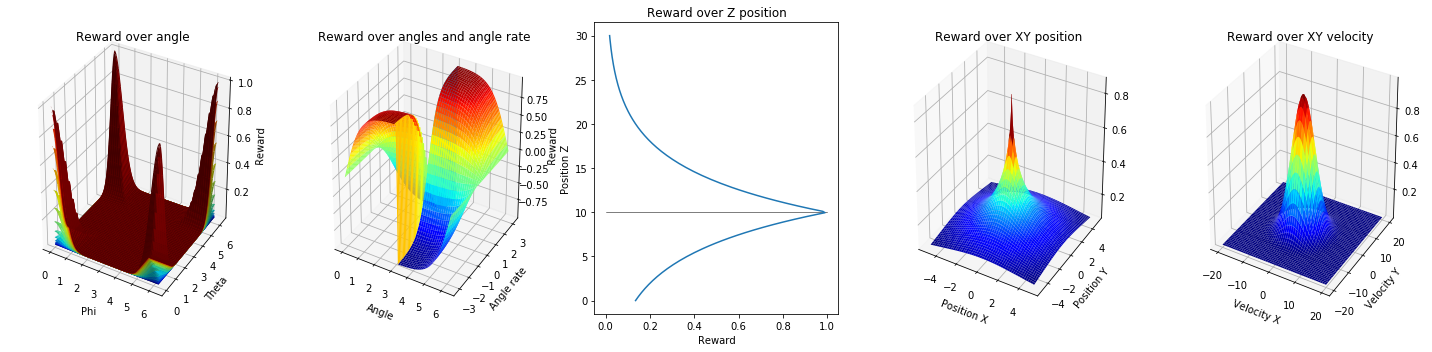

In [70]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from taskHover import TaskHover
env = TaskHover(    positionStart = np.array([0.0, 0.0, 0.0]),
                    positionTarget = np.array([0.0, 0.0, 10.0]),
                    runtime=5,
                    factorPositionZ=1,
                    factorPositionXY=1,
                    factorVelocityXY=1,
                    factorAngles=1,
                    factorAngleRates=1,
                    factorAngleAccels=1,
                    factorGlobal=1
                 )
env.reset()
nValues = 200

# Display plots.
fig = plt.figure(figsize=(20,5))
# y comes first
ax0 = plt.subplot2grid((2, 10), (0, 0), colspan=2, rowspan=2, projection='3d')
ax1 = plt.subplot2grid((2, 10), (0, 2), colspan=2, rowspan=2, projection='3d')
ax2 = plt.subplot2grid((2, 10), (0, 4), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((2, 10), (0, 6), colspan=2, rowspan=2, projection='3d')
ax4 = plt.subplot2grid((2, 10), (0, 8), colspan=2, rowspan=2, projection='3d')

poses = np.column_stack((np.zeros(nValues), np.zeros(nValues), np.linspace(0,30,nValues), np.linspace(0,np.pi,nValues), np.linspace(0,np.pi*2,nValues), np.zeros(nValues)))

# Test angles.
nV = 15
cmap = cm.get_cmap('jet')
colors = [cmap(v) for v in np.linspace(1,0,nV)]
phi = np.linspace(0, 2*np.pi, nValues)
theta = np.linspace(0, 2*np.pi, nValues)
for iv, v in enumerate(np.linspace(0,3,nV)):
    rewardA = np.zeros((nValues,nValues))
    for i in range(nValues):
        for j in range(nValues):
            rewardA[i,j] = env.rewardAngles(np.array([0,0,0,phi[i],theta[j],0]), np.array([float(v),float(v),float(v)]))
    xx, yy = np.meshgrid(phi, theta, indexing='ij')
    #rewardAngles = [env.rewardAngles(p) for p in poses]
    #ax0.plot([0,360],[0,0],c='k',linewidth=0.5)
    #ax0.plot(np.linspace(0,360,nValues), rewardAngles)
    #ax0.plot(np.linspace(0,360,nValues), poses[:,3])
    #ax0.plot(np.linspace(0,360,nValues), poses[:,4])
    foo = ax0.plot_surface(xx, yy, rewardA, linewidth=0, antialiased=True, color=colors[iv])
ax0.set_xlabel('Phi')
ax0.set_ylabel('Theta')
ax0.set_zlabel('Reward')
ax0.set_title('Reward over angle')

# Test angle rates.
angles = np.linspace(0, 2*np.pi, nValues)
angularV = np.linspace(-np.pi, np.pi, nValues)
rewardAV = np.zeros((nValues,nValues))
for i in range(nValues):
    for j in range(nValues):
        rewardAV[i,j] = env.rewardAngleRates(np.repeat(angles[i],3), np.repeat(angularV[j], 3))
xx, yy = np.meshgrid(angles, angularV, indexing='ij')
ax1.plot_surface(xx, yy, rewardAV, cmap='jet', linewidth=0, antialiased=True, vmin=-env.factorAngleRates, vmax=env.factorAngleRates)
#angular_v = np.column_stack((np.linspace(0,3,nValues), np.linspace(0,3,nValues), np.linspace(0,3,nValues)))
#rewardAngleRates = [env.rewardAngleRates(a) for a in angular_v]
#ax3.plot(np.linspace(0,3,nValues), rewardAngleRates)
ax1.set_xlabel('Angle')
ax1.set_ylabel('Angle rate')
ax1.set_zlabel('Reward')
ax1.set_title('Reward over angles and angle rate')

# Test position Z.
rewardPosZ = [env.rewardPositionZ(p) for p in poses]
ax2.plot([0,1],[10,10], c='k', linewidth=0.5)
ax2.plot(rewardPosZ, poses[:,2])
ax2.set_xlabel('Reward')
ax2.set_ylabel('Position Z')
ax2.set_title('Reward over Z position')

# Test position XY
X = np.linspace(-5, 5, nValues*2)
Y = np.linspace(-5, 5, nValues*2)
X, Y = np.meshgrid(X, Y)
posesXY = np.column_stack((X, Y, np.zeros(X.shape)))
rewardXY = []
for i in range(int(nValues*2)):
    for j in range(int(nValues*2)):
        rewardXY.append(env.rewardPositionXY([X[i, j], Y[i, j]]))
rewardXY = np.array(rewardXY).reshape(X.shape)
ax3.plot_surface(X, Y, rewardXY, cmap='jet', linewidth=0, antialiased=True)
ax3.set_xlabel('Position X')
ax3.set_ylabel('Position Y')
ax3.set_title('Reward over XY position')

# Test velocity XY
X = np.linspace(-20, 20, nValues*2)
Y = np.linspace(-20, 20, nValues*2)
X, Y = np.meshgrid(X, Y)
posesXY = np.column_stack((X, Y, np.zeros(X.shape)))
rewardXY = []
for i in range(int(nValues*2)):
    for j in range(int(nValues*2)):
        rewardXY.append(env.rewardVelocityXY([X[i, j], Y[i, j]]))
rewardXY = np.array(rewardXY).reshape(X.shape)
ax4.plot_surface(X, Y, rewardXY, cmap='jet', linewidth=0, antialiased=True)
ax4.set_xlabel('Velocity X')
ax4.set_ylabel('Velocity Y')
ax4.set_title('Reward over XY velocity')


plt.tight_layout()
plt.show()


The plots above show some of the reward functions (from left to right):
* Reward for keeping angles small. This one rewards small angles around the $\phi$ and $\theta$ axes. I figured that this would be one of the most important parts to keep the copter hovering. The angles have direct influence on the velocities and keeping them small makes the copter more controllable (but less agile). The reward is also tied to the angular velocities (represented by the surface color, red: $0$, blue: $2\cdot\pi$ ). This is for the case where the copter starts tumbling and while doing so will pass through the region of small angles again and again. I don't want to reward this so if the angular velocities are high the reward for small angles will be low.
* Reward for angular velocities. I wanted to give the copter an incentive that would bring it back into an upright position so i figured that it would be good to reward it for a certain amount of angular velocity that works *against* a tilt around the $\phi$ and $\theta$ axes. So if the angles are positive a negative angular velocity is rewarded and a positive angular velocity is penalized and the other way round.
* A simple reward for keeping a certain Z position.
* Same for the XY position.
* A reward for keeping the XY velocities low. This should help keeping a certain XY position.

In addition to that there was a reward for small angular accelerations to stabilize the copter and small action values to minimize the amount of energy used for flying.

The reward are plotted for a range of [-1, 1] in this case. For training the copter they were weighted individually so that the total time step reward would be within [-1, 1].

#### Training

The training is basically the same code as for the pendulum, also with the hyper-parameters from the DDPG paper.

The only things I varied to achieve learning were the weights of the reward functions.


Episode =  394, reward sum =  41.002, time elapsed: 1148.5044300556183 seconds

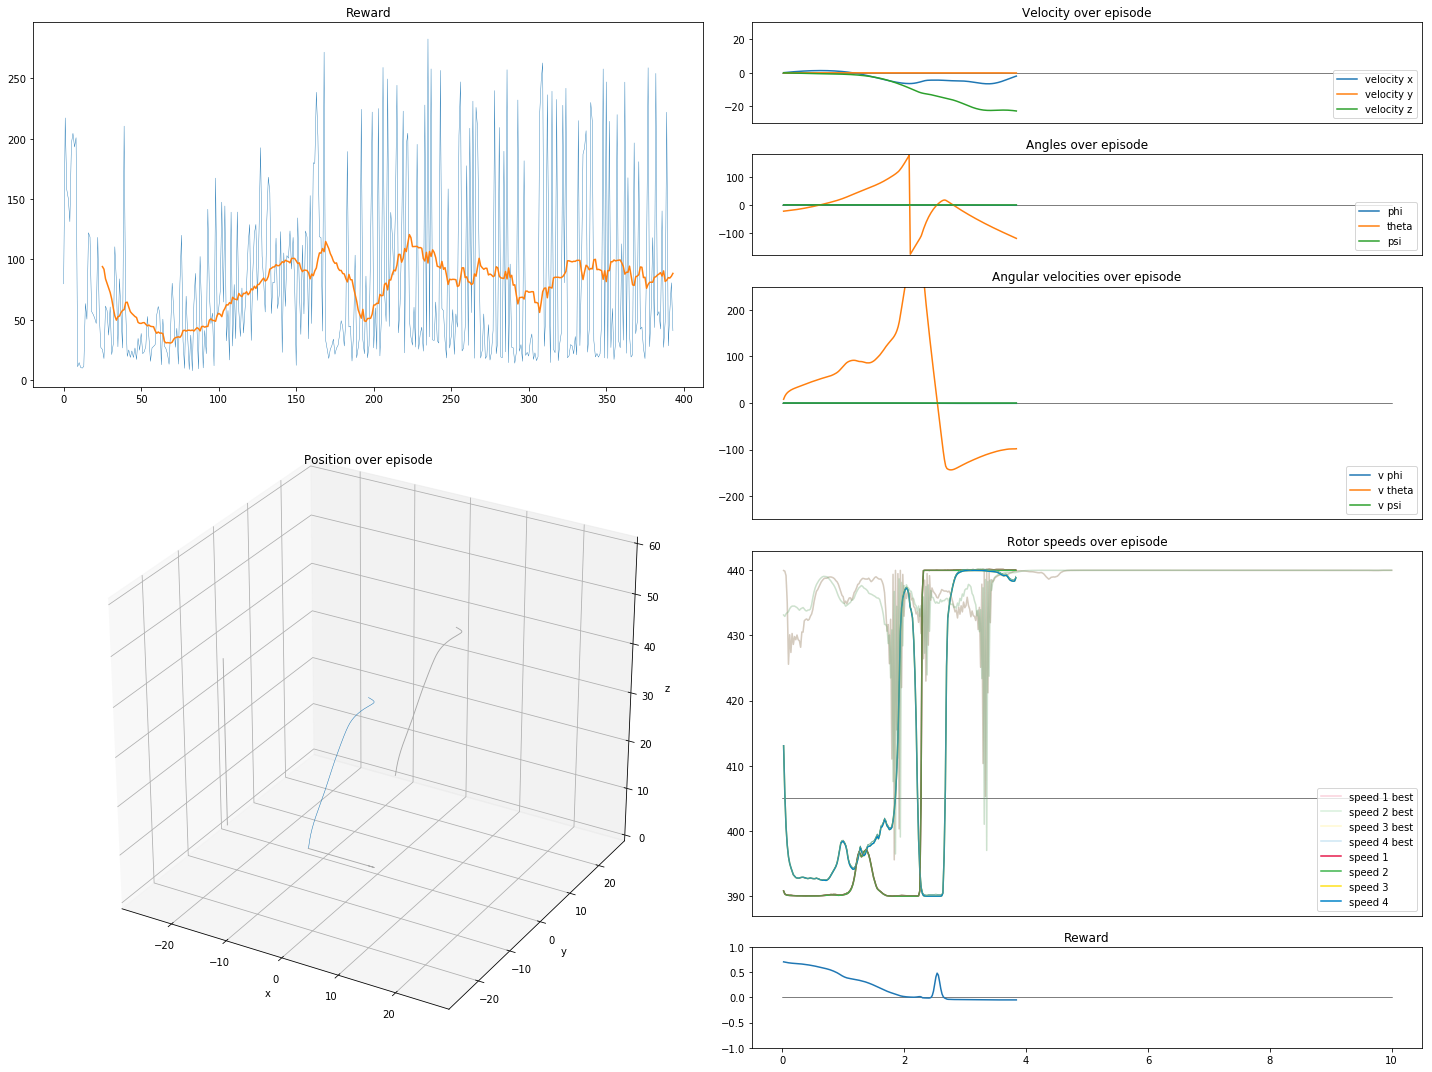

In [ ]:
# Load environment.
%load_ext autoreload
%autoreload 2

from IPython import display
import sys
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import tensorflow as tf
import tflearn
import gym
from agentDDPGTflearn import AgentDDPG
from taskHover import TaskHover
import time



# Hyperparameters. These are the original values from the DDPG paper.
hp = {}
hp['noiseMu'] = 0.0
hp['noiseTheta'] = 0.15
hp['noiseSigmaStart'] = 0.2
hp['noiseSigmaEnd'] = 0.2
hp['noiseDecay'] = 0.01
# Discount factor.
hp['gamma'] = 0.99
# Soft update factor for target params.
hp['tau'] = 0.0005
# Actor network parameters.
hp['actorActivation'] = 'relu'
hp['actorBatchNorm'] = True
hp['actorLearningRate'] = 0.0001
hp['actorDropout'] = False
hp['actorDropoutRate'] = 0.1
# Critic network parameters.
hp['criticActivation'] = 'relu'
hp['criticBatchNorm'] = True
hp['criticLearningRate'] = 0.001
hp['criticDropout'] = False
hp['criticDropoutRate'] = 0.1
# Replay buffer.
hp['bufferSize'] = 1000000
hp['batchSize'] = 64
hp['nReplayBatches'] = 1
# Random seed.
hp['randomSeed'] = 1234
hp['renderGym'] = False


num_episodes = 3000
rewardSums = []
resultsAll = []
rewardMax = 0
resultsRewardMax = None

# Clear tensorflow graph and all variables.
# Otherwise we cannot run this cell multiple times
# without restarting the kernel.
tf.reset_default_graph()

with tf.Session() as sess:

    tf.set_random_seed(int(hp['randomSeed']))

    # Set up environment.
    print("Creating environment... ", end='')
    # Create environment
    # Set start position high above ground so we have some time to learn until we crash :)
    runtime = 10
    env = TaskHover(positionStart = np.array([0.0, 0.0, 40.0]),
                    positionTarget = np.array([0.0, 0.0, 40.0]),
                    nActionRepeats=1,
                    runtime=runtime,
                    factorPositionZ=0.15,
                    factorPositionXY=0.0,
                    factorVelocityXY=0.3,
                    factorAngles=0.5,
                    factorAngleRates=0.0,
                    factorAngleAccels=0.0,
                    factorActions=0.05,
                    factorGlobal=1,
                    angleNoise=30.0,
                    angleRateNoise=5.0,
                    positionStartNoise=5.0)
    env.reset()
    print("Done.")
    print("   Action space: continuous from {} to {}.".format(env.action_space.low[0], env.action_space.high[0]))
    print("   State space: continuous, {}-dimensional.".format(env.observation_space.shape[0]))

    # Create agent.
    agent = AgentDDPG(sess, env, hp)
    print("Agent created.")

    # Data recording.
    rewardSums = []
    actions = []
    positions = []
    velocities = []

    timeStart = time.time()
    
    print("Starting training.")
    for i_episode in range(1, num_episodes+1):
        t = 0
        rewardRecord = []
        actionRecord = []
        stateRecord = []
        noiseRecord = []

        # Specify values to be tracked. #################################################
        labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
                  'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
                  'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'noise_1', 'noise_2', 'noise_3', 'noise_4', 'reward']
        results = {x : [] for x in labels}

        # Reset the agent.
        # This resets the noise sampler and the environment.
        state = agent.reset_episode()

        while True:

            stateRecord.append(state.squeeze())

            # Choose an action.
            # This lets the actor predict a new action
            # plus adding some noise for exploration.
            action, noise = agent.act(state)
            # Convert to 4 speeds.
            # First two rotors are the ones on the left side, last two are on the right side.
            rotor_speeds = [action[0][0], action[0][0], action[0][1], action[0][1]]
            noise = [noise[0], noise[0], noise[1], noise[1]]
            actionRecord.append(rotor_speeds)
            noiseRecord.append(noise)

            # Let the environment react to the chosen action.
            next_state, reward, done, info = env.step(rotor_speeds)

            # Let the agent process the next state and reward.
            # This adds the results to memory and does a learning
            # step if enough memory tuples have been recorded.
            # Feed in the original 2-d action!
            agent.step(action, reward, next_state, done)

            # Set new current state.
            state = next_state 
            
            # Save data.
            #rewardSums.append(agent.rewardSum)
            #actions.append(actionRecord)
            #positions.append(list(np.array(stateRecord)[:,0]))
            #velocities.append(list(np.array(stateRecord)[:,1]))
            # Put all current date into a list with order corresponding to the label list.
            data = [env.sim.time] + list(env.sim.pose) + list(env.sim.v) + list(env.sim.angular_v) + list(rotor_speeds) + list(noise) +[reward]
            for iLabel, label in enumerate(labels):
                results[label].append(data[iLabel])

            if done:
                if i_episode == 0:
                    rewardMax = agent.rewardSum
                # Save best episode.
                if agent.rewardSum > rewardMax:
                    rewardMax = agent.rewardSum
                    resultsRewardMax = results

                # Decay noise.
                #agent.noise.decay()

                rewardSums.append(agent.rewardSum)
                resultsAll.append([results, agent.rewardSum])

                # Display 
                display.clear_output(wait=True)
                print("\rEpisode = {:4d}, reward sum = {:7.3f}, time elapsed: {:} seconds".format(
                    i_episode, agent.rewardSum, time.time()-timeStart), end="")

                # Display plots.
                fig = plt.figure(figsize=(20,15))
                # y comes first
                ax0 = plt.subplot2grid((8, 10), (0, 0), colspan=5, rowspan=3)
                ax1 = plt.subplot2grid((8, 10), (3, 0), colspan=5, rowspan=5, projection='3d')
                ax2 = plt.subplot2grid((8, 10), (0, 5), colspan=5, rowspan=1)
                ax3 = plt.subplot2grid((8, 10), (1, 5), colspan=5, rowspan=1)
                ax4 = plt.subplot2grid((8, 10), (2, 5), colspan=5, rowspan=2)
                ax5 = plt.subplot2grid((8, 10), (4, 5), colspan=5, rowspan=3)
                ax6 = plt.subplot2grid((8, 10), (7, 5), colspan=5, rowspan=1)

                # Sample the state space to get some action values.
                # Plot reward.
                runningAvgLength = 25
                ax0.plot(rewardSums, linewidth=0.4)
                if len(rewardSums) > runningAvgLength:
                    rewardSumsAvg = []
                    for i in range(runningAvgLength, len(rewardSums)):
                        rewardSumsAvg.append(np.mean(rewardSums[i-runningAvgLength:i]))
                    ax0.plot(range(runningAvgLength,len(rewardSums)), rewardSumsAvg)
                ax0.set_title('Reward')
                #ax0.set_ylim(-100, 0)

                # Plot position.
                plotLimitXY = 28
                plotLimitZ = 60
                ax1.plot(results['x'], results['y'], results['z'], markersize=0.8, linewidth=0.5)
                # Plot projections.
                xLimited = [x for x in results['x'] if np.abs(x) <= plotLimitXY]
                yLimited = [y for y in results['y'] if np.abs(y) <= plotLimitXY]
                zLimited = [z for z in results['z'] if z <= plotLimitZ]
                l = min(len(xLimited), len(yLimited))
                ax1.plot(xLimited[0:l], yLimited[0:l], np.repeat(0.0, l), c='darkgray', linewidth=0.9)
                l = min(len(xLimited), len(zLimited))
                ax1.plot(xLimited[0:l], np.repeat(plotLimitXY, l), zLimited[0:l], c='darkgray', linewidth=0.9)
                l = min(len(yLimited), len(zLimited))
                ax1.plot(np.repeat(-plotLimitXY, l), yLimited[0:l], zLimited[0:l], c='darkgray', linewidth=0.9)
                ax1.set_ylim(-plotLimitXY, plotLimitXY)
                ax1.set_xlim(-plotLimitXY, plotLimitXY)
                ax1.set_zlim(0, plotLimitZ)
                ax1.set_xlabel('x')
                ax1.set_ylabel('y')
                ax1.set_zlabel('z')
                ax1.set_title('Position over episode')

                # Plot velocities 2d.
                ax2.plot([0, runtime], [0,0], c='k', linewidth=0.5)
                ax2.plot(results['time'], results['x_velocity'], label='velocity x')
                ax2.plot(results['time'], results['y_velocity'], label='velocity y')
                ax2.plot(results['time'], results['z_velocity'], label='velocity z')
                ax2.set_ylim(-30, 30)
                ax2.set_title('Velocity over episode')
                ax2.legend(loc=4)
                ax2.set_xticks([])

                # Plot angles.
                ax3.plot([0, runtime], [0,0], c='k', linewidth=0.5)
                ax3.plot(results['time'], [a*180/np.pi if a<= np.pi else (a-2*np.pi)*180/np.pi for a in results['phi']], label='phi')
                ax3.plot(results['time'], [a*180/np.pi if a<= np.pi else (a-2*np.pi)*180/np.pi for a in results['theta']], label='theta')
                ax3.plot(results['time'], [a*180/np.pi if a<= np.pi else (a-2*np.pi)*180/np.pi for a in results['psi']], label='psi')
                ax3.legend(loc=4)
                ax3.set_ylim(-180, 180)
                ax3.set_title('Angles over episode')
                ax3.set_xticks([])

                # Plot angular velocities.
                ax4.plot([0, runtime], [0,0], c='k', linewidth=0.5)
                ax4.plot(results['time'], [a*180/np.pi for a in results['phi_velocity']], label='v phi')
                ax4.plot(results['time'], [a*180/np.pi for a in results['theta_velocity']], label='v theta')
                ax4.plot(results['time'], [a*180/np.pi for a in results['psi_velocity']], label='v psi')
                ax4.legend(loc=4)
                ax4.set_ylim(-250, 250)
                ax4.set_title('Angular velocities over episode')
                ax4.set_xticks([])

                # Plot actions.
                colors = np.array([ [230, 25, 75, 255],
                            [60, 180, 75, 255],
                            [255, 225, 25, 255],
                            [0, 130, 200, 255]]) / 255.
                ax5.plot([0, runtime], [405,405], c='k', linewidth=0.5)

                if resultsRewardMax != None:
                    ax5.plot(resultsRewardMax['time'], [a - n for a, n in zip(resultsRewardMax['rotor_speed1'], resultsRewardMax['noise_1'])], c=list(colors[0])[:3]+[0.2], label='speed 1 best')
                    ax5.plot(resultsRewardMax['time'], [a - n for a, n in zip(resultsRewardMax['rotor_speed2'], resultsRewardMax['noise_2'])], c=list(colors[1])[:3]+[0.2], label='speed 2 best')
                    ax5.plot(resultsRewardMax['time'], [a - n for a, n in zip(resultsRewardMax['rotor_speed3'], resultsRewardMax['noise_3'])], c=list(colors[2])[:3]+[0.2], label='speed 3 best')
                    ax5.plot(resultsRewardMax['time'], [a - n for a, n in zip(resultsRewardMax['rotor_speed4'], resultsRewardMax['noise_4'])], c=list(colors[3])[:3]+[0.2], label='speed 4 best')

                ax5.plot(results['time'], [a - n for a, n in zip(results['rotor_speed1'], results['noise_1'])], c=colors[0], label='speed 1')
                ax5.plot(results['time'], [a - n for a, n in zip(results['rotor_speed2'], results['noise_2'])], c=colors[1], label='speed 2')
                ax5.plot(results['time'], [a - n for a, n in zip(results['rotor_speed3'], results['noise_3'])], c=colors[2], label='speed 3')
                ax5.plot(results['time'], [a - n for a, n in zip(results['rotor_speed4'], results['noise_4'])], c=colors[3], label='speed 4')

                ax5.plot(results['time'], results['rotor_speed1'], c=colors[0], linewidth=0.5)
                ax5.plot(results['time'], results['rotor_speed2'], c=colors[1], linewidth=0.5)
                ax5.plot(results['time'], results['rotor_speed3'], c=colors[2], linewidth=0.5)
                ax5.plot(results['time'], results['rotor_speed4'], c=colors[3], linewidth=0.5)
                ax5.legend(loc=4)
                ax5.set_ylim(env.action_low-3, env.action_high+3)
                ax5.set_title('Rotor speeds over episode')
                ax5.set_xticks([])

                # Plot rewards.
                ax6.plot([0, runtime], [0,0], c='k', linewidth=0.5)
                ax6.plot(results['time'], results['reward'])
                ax6.set_ylim(-1, 1)
                ax6.set_title('Reward')


                plt.tight_layout()
                plt.show()

                #plot.plot(results, fancy=False)
                break
            t += 1
#env.close()

# Free memory.
#env.close()
del env
del sess
del agent
for i in range(10): gc.collect()

In [80]:
# Save results for video.
import pickle
with open('results2.bin', 'wb') as pickleFile:
    pickle.dump(resultsAll, pickleFile)

In [81]:
# Run this if cell above was interrupted manually.
import gc
del env
del sess
del agent
for i in range(10): gc.collect()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: Please see the cells above for a description of the task and reward components.

The reward function finally ended up with the following weights:
* position Z: 0.15
* position XY: 0.0
* velocityXY: 0.3
* angles: 0.5
* angular velocities: 0.0
* angular accelerations: 0.0
* actions: 0.05

I have made the following experiences:
* the key to hovering -- at least for me -- was minimizing the angles (however, I think this would conflict with moving somewhere as this will need a certain angle to have a lateral thrust component)
* keeping a certain position, especially in XY, is very hard to achieve. This is -- at least that's what I think -- because we somehow have to bound the reward function to [-1, 1] so the reward will not change anymore if a certain distance from the target point is reached.
* velocities are better for keeping the current position. They change much more quickly than the positions so it is easier for the agent to react to them
* rewarding angles alone does not suffice for keeping an XY position because very small angles will already impose quite high lateral velocities. Therefore a combination of XY velocities and angles is necessary.
* having reward weights that are very similar in value seems to confuse the agent because (I guess) it does not know why a certain action was rewarded. It seemed to help to have the weights distributed non-equally with the most important reward the highest and others smaller and smaller.


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

At first I used the DDPG agent provided.
When it did not seem to learn the pendulum task I gradually added more and more features that were also used by Lillicrap 2016:
- Actor and critic networks have two hidden layers with 400 and 300 each
- The critic includes the action inputs at the second layer
- Batch normalization is added to all layers except the output layers
- Random uniform weight and bias initializers with limits [-3e-3, 3e-3] for the output layers
- L2 weight decay for critic
- Use tanh activation for actions as it has zero mean ([source](https://dl-nd.slack.com/archives/C3QVCQHGW/p1525815705000352))

Then, once I found out that -- at least for me -- the code would not result in the desired learning I switched to a differnt code (see above in the Pendulum II section) that worked better.
I used the same architecture and hyper-parameters and also implemented the $[-\frac{1}{\sqrt{f}},  \frac{1}{\sqrt{f}}]$ weight initalization for the hidden layers.


**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

The agent first starts of with some high rewards because it drives the actions to the max which sometimes levels the copter. This behaviour is quickly broken by the noisy start conditions. From then on the episode rewards follow a wavy curve that generally goes upwards. There seemed to be some slight aha moments when the curve started to increase steeply. It would then decrease again but not as low as is climbed before. However, there is no "now the learning is complete" moment so far...

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

To be honest, this was the most frustrating project in my entire life.

I first used the OpenAI pendulum environment to check if my agent was able to train. Once that seemed to work I switched to the copter. I saw peoples results for the take-off task on slack. Mostly, all rotors where driven to the max action values which I didn't really regard 'learning' because it does not really achieve control in a sense of balancing something.

With this in mind I went straight to the hover task just to fail for about two months. I designed different reward functions involving the vertical and lateral positions in relation to a target point, the angles, angular velocities and accelerations but to no avail. It just wouldn't fly. In case of rewarding a level orientation most of the time it learned to drive two opposing rotors to the max and the others to the min. In an undisturbed environment this keeps the copter stable but is also not 'true' control.

I slowly realized that to learn the optimal policy a lot had to go right at the same time and the optimization space if full of local minima (like the 2 on, 2 off scenario).

Designing reward functions for the 3d case is kind of hard because they are ambiguous. The copter might behave great around one axis and get's punished nevertheless for misbehaving on the other axis. Averaging axes can lead to nullifications and taking the max let's it not 'see' it's mistakes. I then switched over to constraining the copter to a 2-dimensional problem in the XZ plane by combining two rotors into one action.

At some point I had no idea why the agent would not learn and also my mentor ran out of hints (although he did a good job in general). I then found that tflearn code for DDPG just one week before the deadline, tried it and it worked like a charm. I essentially spent a lot of time trying to tune my reward functions while the true culprit was the Keras code provided in the project...

However, all in all, it came to a good end and I guess I've learned a lot...
